In [10]:
# cnn EOG model for last control right/left/none 

import numpy as np
from scipy.stats import skew,kurtosis
import pandas as pd 
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import accuracy_score, classification_report
from scipy.integrate import trapz 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

def extract_shape_features(data):
    features = []
    for i in range(data.shape[0]):
        signal = data[i, :]
        duration = len(signal)
        peak_amplitude = np.max(signal)
        valley_amplitude = np.min(signal)
        mean_amplitude = np.mean(signal)
        time_to_peak = np.argmax(signal)
        time_to_valley = np.argmin(signal)
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        zero_crossing_rate = len(zero_crossings) / duration
        
        signal_slope = np.gradient(signal)
        rise_time = np.where(signal >= peak_amplitude)[0][0]
        fall_time = duration - np.where(signal[::-1] >= peak_amplitude)[0][0]
        signal_curvature = np.gradient(signal_slope)
        inflection_points = np.where(np.diff(np.sign(signal_curvature)))[0]
        
        crest_factor = peak_amplitude / np.sqrt(np.mean(np.square(signal)))

        skew_val = skew(signal)
        kurt_val = kurtosis(signal)

        std_deviation = np.std(signal)
        variance = np.var(signal)
        median = np.median(signal)
        min_to_max_ratio = valley_amplitude / peak_amplitude
        mean_abs_deviation = np.mean(np.abs(signal - mean_amplitude))
        area_under_curve = trapz(signal)
        
        features.append([peak_amplitude, valley_amplitude, 
                         time_to_peak,time_to_valley, rise_time, fall_time,
                         len(inflection_points), crest_factor, skew_val, kurt_val,
                         std_deviation, variance, median, min_to_max_ratio, mean_abs_deviation])

    return np.array(features)

right = pd.read_csv('C:/Users/PC/Desktop/new_signal_right.csv')
left = pd.read_csv('C:/Users/PC/Desktop/new_signal_left.csv')
none = pd.read_csv('C:/Users/PC/Desktop/bos_resampled.csv')

right_signal =[]
left_signal =[]
none_signal = []

right_signal.append(right)
left_signal.append(left)
none_signal.append(none)

size_left = np.array(left_signal)
size_right = np.array(right_signal)
size_none = np.array(none_signal)

size_left = size_left.reshape(size_left.shape[1],size_left.shape[2])
size_right = size_right.reshape(size_right.shape[1],size_right.shape[2])
size_none = size_none.reshape(size_none.shape[1],size_none.shape[2])

# RIGHT FEATURES
right_features = extract_shape_features(size_right)

# LEFT FEATURES
left_features = extract_shape_features(size_left)

# NONE FEATURES
none_features = extract_shape_features(size_none)

all_features_combined = np.concatenate((right_features, left_features,none_features), axis=0)

data_order = [0] * 300 + [1] * 300 + [2] * 298
y_train = np.array(data_order)

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

X_train, X_test, y_train, y_test = train_test_split(all_features_combined,y_train_encoded, test_size=0.2)

print(X_train.shape)

model = keras.Sequential([
    keras.layers.Input(shape=(15,)),
    keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

y_train_one_hot = keras.utils.to_categorical(y_train, num_classes=3)
y_test_one_hot = keras.utils.to_categorical(y_test, num_classes=3)

history = model.fit(X_train, y_train_one_hot, epochs=100, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

model.save("cnn_model_left_right_cokdata_2.h5",model)
model.summary()


(718, 15)
Epoch 1/100
18/18 [==============================] - 1s 14ms/step - loss: 2.0546 - accuracy: 0.5836 - val_loss: 2.0780 - val_accuracy: 0.6250
Epoch 2/100
18/18 [==============================] - 0s 10ms/step - loss: 1.4919 - accuracy: 0.8118 - val_loss: 1.2810 - val_accuracy: 0.8750
Epoch 3/100
18/18 [==============================] - 0s 9ms/step - loss: 1.2799 - accuracy: 0.8693 - val_loss: 1.0902 - val_accuracy: 0.8958
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 1.1273 - accuracy: 0.9094 - val_loss: 0.9827 - val_accuracy: 0.9167
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 1.0762 - accuracy: 0.9024 - val_loss: 0.8888 - val_accuracy: 0.9444
Epoch 6/100
18/18 [==============================] - 0s 7ms/step - loss: 0.9879 - accuracy: 0.9042 - val_loss: 0.8240 - val_accuracy: 0.9583
Epoch 7/100
18/18 [==============================] - 0s 6ms/step - loss: 0.8888 - accuracy: 0.9216 - val_loss: 0.7731 - val_accuracy: 0.9583
E

Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2375 - accuracy: 0.9443 - val_loss: 0.2901 - val_accuracy: 0.8958
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2285 - accuracy: 0.9355 - val_loss: 0.2284 - val_accuracy: 0.9583
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2268 - accuracy: 0.9408 - val_loss: 0.2308 - val_accuracy: 0.9514
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 0.2019 - accuracy: 0.9547 - val_loss: 0.2195 - val_accuracy: 0.9514
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 0.2303 - accuracy: 0.9408 - val_loss: 0.2049 - val_accuracy: 0.9653
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 0.1996 - accuracy: 0.9564 - val_loss: 0.2576 - val_accuracy: 0.9444
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 0.2569 - accuracy: 0.9268 - val_loss: 0.2231 - val_accuracy: 0.9653
Epoch 

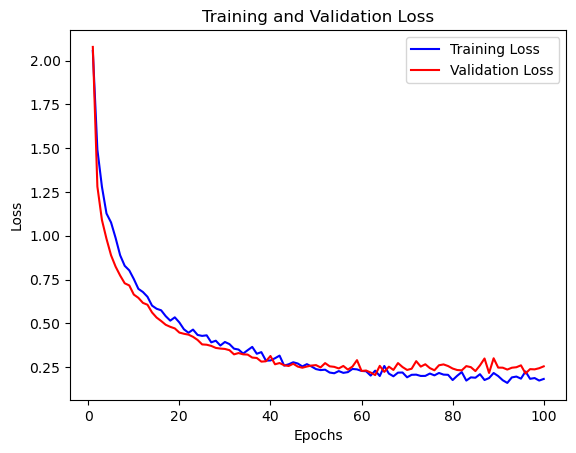

In [11]:
import matplotlib.pyplot as plt

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(training_loss) + 1)

plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [1]:
from tensorflow import keras
import joblib
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.integrate import trapz

def extract_shape_features(data):
    features = []
    for i in range(data.shape[0]):
        signal = data[i, :]
        duration = len(signal)
        peak_amplitude = np.max(signal)
        valley_amplitude = np.min(signal)
        mean_amplitude = np.mean(signal)
        time_to_peak = np.argmax(signal)
        time_to_valley = np.argmin(signal)
        zero_crossings = np.where(np.diff(np.sign(signal)))[0]
        zero_crossing_rate = len(zero_crossings) / duration
        
        signal_slope = np.gradient(signal)
        rise_time = np.where(signal >= peak_amplitude)[0][0]
        fall_time = duration - np.where(signal[::-1] >= peak_amplitude)[0][0]
        signal_curvature = np.gradient(signal_slope)
        inflection_points = np.where(np.diff(np.sign(signal_curvature)))[0]
        
        crest_factor = peak_amplitude / np.sqrt(np.mean(np.square(signal)))

        skew_val = skew(signal)
        kurt_val = kurtosis(signal)

        std_deviation = np.std(signal)
        variance = np.var(signal)
        median = np.median(signal)
        min_to_max_ratio = valley_amplitude / peak_amplitude
        mean_abs_deviation = np.mean(np.abs(signal - mean_amplitude))
        area_under_curve = trapz(signal)
        
        features.append([peak_amplitude, valley_amplitude, 
                         time_to_peak,time_to_valley, rise_time, fall_time,
                         len(inflection_points), crest_factor, skew_val, kurt_val,
                         std_deviation, variance, median, min_to_max_ratio, mean_abs_deviation])

    return np.array(features)



def read_txt_file(file_path):
    with open(file_path, 'r') as file:
        eog_signal = np.loadtxt(file)
        return eog_signal


eog_signal = read_txt_file("C:/Users/PC/EOG/maho_txt/maho right.txt")

loaded_model = keras.models.load_model('cnn_model_left_right_cokdata_2.h5')

eog_signal = eog_signal.reshape(1,eog_signal.shape[0])
new_data = extract_shape_features(eog_signal)
predictions = loaded_model.predict(new_data)

predicted_labels = predictions.argmax(axis=1)

class_labels = ['right', 'left', 'none']
predicted_human_readable_labels = [class_labels[i] for i in predicted_labels]

print("Predicted Labels:", predicted_human_readable_labels)


Predicted Labels: ['right']
